In [1]:
# Importar librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as rp

In [2]:
from sklearn import preprocessing
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [3]:
# Especificar columnas
relevant_columns = ['SKU','Categoria','FORMATO','Existencia','fiDesplazamiento','VentaPromedio','Y_Faltante']
num_columns = ['Existencia','fiDesplazamiento','VentaPromedio']
cat_columns = ['SKU','Categoria','FORMATO']
target = ['Y_Faltante']

In [4]:
# Abrir el archivo que contiene el conjunto de validación 
file_val = 'datos_prueba.csv'
data_val = pd.read_csv(file_val, header=0,low_memory=False, encoding='latin-1',usecols=relevant_columns)
print('rows:', data_val.shape[0], ' columns:', data_val.shape[1])

rows: 842788  columns: 7


In [5]:
data_val_limpio = data_val.dropna(subset=relevant_columns)

In [6]:
data_val_limpio.to_csv('validacion_limpio.csv',index=True)

In [7]:
dtype = {'SKU':'object','FORMATO':'object','REGION':'object','Tienda':'object','Categoria':'object','Proveedor':'object','CLASE':'object','SCLASE':'object','Mes':'object','DiaSem':'object','Sem':'object','Decil':'object','Existencia':'float','fiDesplazamiento':'float',
\
'VentaPromedio':'float','Y_Faltante':'int'}

In [8]:
# Abrir el archivo
file = 'datos_entrenamiento.csv'
data = pd.read_csv(file, header=0,low_memory=False, encoding='latin-1',usecols=relevant_columns,dtype=dtype)
print('rows:', data.shape[0], ' columns:', data.shape[1])

rows: 5094322  columns: 7


In [9]:
# Abrir el archivo que contiene el conjunto de validación 
file_val = 'validacion_limpio.csv'
#file_val = 'datos_prueba.csv'
data_val = pd.read_csv(file_val, header=0,low_memory=False, encoding='latin-1',usecols=relevant_columns,dtype=dtype)
print('rows:', data_val.shape[0], ' columns:', data_val.shape[1])

rows: 808828  columns: 7


In [10]:
data_val = data_val.sample(frac=1).reset_index(drop=True)
data_val

,SKU,FORMATO,Categoria,Existencia,fiDesplazamiento,VentaPromedio,Y_Faltante
0,3618668,SUPER CHEDRAUI CD,DULCES Y CHOCOLATES,121.0,110.0,640.20,0
1,3141178,SUPER CHEDRAUI CD,DESECHABLE COCINA,331.0,67.0,2928.57,1
2,3705562,SUPER CHEDRAUI CD,DESODORANTES CABALLERO,0.0,0.0,0.00,1
3,3653073,CHEDRAUI CD,SALSAS,7.0,9.0,223.74,0
4,3419939,CHEDRAUI CD,VELAS Y VELADORAS,10.0,10.0,1103.00,1
...,...,...,...,...,...,...,...
808823,3691231,CHEDRAUI CD,AGUARDIENTES,0.0,5.0,0.00,1
808824,3108795,CHEDRAUI CD,ARTÃCULOS DE COCCIÃN,14.0,16.0,3061.76,1
808825,3074553,CHEDRAUI AB,ALIMENTACIÃN SECA,53.0,116.0,12899.20,0
808826,3678422,CHEDRAUI CD,JAMONES,0.0,2.0,0.00,1


In [11]:
# Aislamos las variables numéricas y realizamos un min-max scaling sobre ellas
categorical = data.drop(columns=['Existencia','fiDesplazamiento','VentaPromedio','Y_Faltante'])
numerical = data[['Existencia','fiDesplazamiento','VentaPromedio']]
numerical_scaled = (numerical - numerical.min())/(numerical.max() - numerical.min()) 
faltante = data["Y_Faltante"]

In [12]:
scaled_data = pd.concat([categorical,numerical_scaled,faltante], axis=1)
data = scaled_data

In [13]:
data = data.dropna()
data_val = data_val.dropna()

In [14]:
data.dtypes

SKU                  object
FORMATO              object
Categoria            object
Existencia          float64
fiDesplazamiento    float64
VentaPromedio       float64
Y_Faltante            int64
dtype: object

In [15]:
def segmentador_formato(frame,cadena):
    arreglo = frame[frame['FORMATO']==cadena]
    return arreglo 

## CHEDRAUI CD

In [16]:
chedraui_cd = segmentador_formato(data,'CHEDRAUI CD')
chedraui_cd_val = segmentador_formato(data_val,'CHEDRAUI CD')

yes %: 50.38754984598272- no %: 49.61245015401728


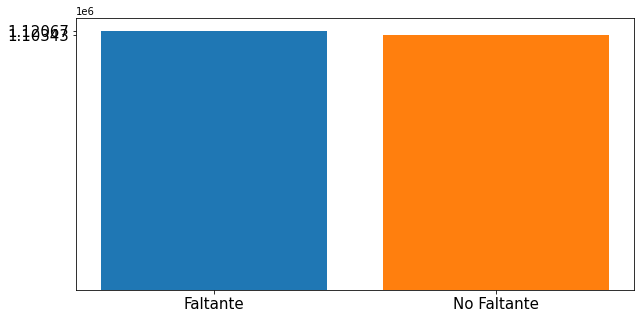

In [17]:
# Revisamos la proporción de datos
target = chedraui_cd['Y_Faltante']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Faltante", yes)
plt.bar("No Faltante", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [18]:
#Balanceamos a 50% - 50% nuestro conjunto de datos.
data_yes = chedraui_cd[chedraui_cd["Y_Faltante"] == 1]
data_no = chedraui_cd[chedraui_cd["Y_Faltante"] == 0]
over_sampling = data_yes.sample(no, replace=True, \
random_state = 0)
balanced_data = pd.concat([data_no, over_sampling], \
axis=0)
chedraui_cd = balanced_data.reset_index(drop=True)

yes %: 50.0- no %: 50.0


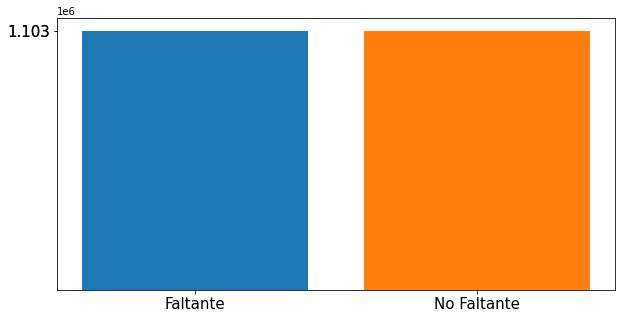

In [19]:
# Verificamos que el conjunto de datos está perfectamente balanceado
# Revisamos la proporción de datos
target = chedraui_cd['Y_Faltante']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Faltante", yes)
plt.bar("No Faltante", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [20]:
chedraui_cd = chedraui_cd.drop('FORMATO',axis=1)
chedraui_cd_val = chedraui_cd_val.drop('FORMATO',axis=1)

In [21]:
X_train = chedraui_cd.drop('Y_Faltante',axis=1)
y_train = chedraui_cd.Y_Faltante
X_val = chedraui_cd_val.drop('Y_Faltante',axis=1)
y_val = chedraui_cd_val.Y_Faltante

In [22]:
indices_categoricos = np.where(X_train.dtypes != float)[0]
indices_categoricos

array([0, 1])

In [23]:
num_ind = np.where(X_train.dtypes != object)[0]
num_ind

array([2, 3, 4])

In [24]:
indices_categoricos = np.where(X_train.dtypes != float)[0]
indices_categoricos

array([0, 1])

In [25]:
num_ind = np.where(X_train.dtypes != object)[0]
num_ind

array([2, 3, 4])

In [26]:
model = CatBoostClassifier(
    l2_leaf_reg=int(1.0),
    custom_loss=[metrics.Accuracy()],
    random_seed=0,
    logging_level='Verbose', # Write 'Silent' instead of 'verbose'
    task_type='GPU',
    iterations=160
)

In [27]:
model.fit(
    X_train, y_train,
    cat_features=indices_categoricos,
    eval_set=(X_val, y_val),
    logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6707916	test: 0.6714958	best: 0.6714958 (0)	total: 41.1ms	remaining: 6.54s
1:	learn: 0.6497316	test: 0.6516586	best: 0.6516586 (1)	total: 92.4ms	remaining: 7.3s
2:	learn: 0.6298629	test: 0.6328129	best: 0.6328129 (2)	total: 144ms	remaining: 7.51s
3:	learn: 0.6111041	test: 0.6150243	best: 0.6150243 (3)	total: 194ms	remaining: 7.56s
4:	learn: 0.5933715	test: 0.5982720	best: 0.5982720 (4)	total: 245ms	remaining: 7.59s
5:	learn: 0.5766211	test: 0.5826888	best: 0.5826888 (5)	total: 296ms	remaining: 7.59s
6:	learn: 0.5607154	test: 0.5679191	best: 0.5679191 (6)	total: 346ms	remaining: 7.56s
7:	learn: 0.5456397	test: 0.5537150	best: 0.5537150 (7)	total: 390ms	remaining: 7.41s
8:	learn: 0.5313399	test: 0.5407701	best: 0.5407701 (8)	total: 429ms	remaining: 7.19s
9:	learn: 0.5177464	test: 0.5280542	best: 0.5280542 (9)	total: 479ms	remaining: 7.18s
10:	learn: 0.5048219	test: 0.5161025	best: 0.5161025 (10)	total: 529ms	remaining: 7.17s
11:	learn: 0.4925183	test: 0.5047791	best: 0.504779

In [28]:
print('Ago Model')
print('Tree count: {}'.format(model.tree_count_))
print('Accuracy: {:.5}'.format(accuracy_score(y_val, model.predict(X_val))))
print('True Positive Rate: {:.5}'.format(recall_score(y_val, model.predict(X_val))))
print('Precision: {:.5}'.format(precision_score(y_val, model.predict(X_val))))
print('Balanced Accuracy: {:.5}'.format(balanced_accuracy_score(y_val, model.predict(X_val))))
print('F1 Score: {:.5}'.format(f1_score(y_val, model.predict(X_val))))

Ago Model
Tree count: 145
Accuracy: 0.90324
True Positive Rate: 0.84846
Precision: 0.95342
Balanced Accuracy: 0.90339
F1 Score: 0.89788


In [29]:
y_pred = model.predict(X_val)
prediction_probs = model.predict_proba(X_val)

accuracy = accuracy_score(y_val,y_pred)
recall = recall_score(y_val,y_pred,average='binary',pos_label=1)
precision = precision_score(y_val,y_pred,average='binary',pos_label=0)
balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred,pos_label=1)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.9032432994998932
True Positive Rate 0.848457533692796
Precision 0.8628247034214703
Balanced accuracy 0.9033907421197803
f1 score 0.8978811967047261


In [30]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
tn,fp,fn,tp

(174483, 7588, 27740, 155311)

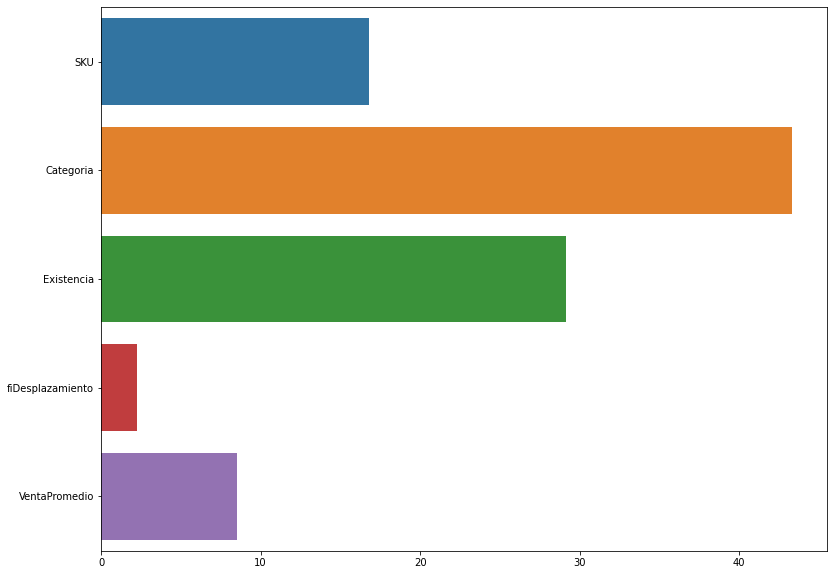

In [31]:
# Graficar la importancia de las variables
fi2 = pd.Series(model.feature_importances_, index=X_train.columns)
fig, ax = plt.subplots(figsize = (13,10))
sns.barplot(x=fi2.values, y=fi2.index, ax=ax)
plt.show()

# Intento por incorporar random forests

In [32]:
# Predicciones del conjunto de validación
y_pred_train = model.predict(X_train)
y_prob_train = model.predict_proba(X_train)
pred_cb_train = pd.DataFrame(y_prob_train).assign(CBPred=pd.Series(y_pred_train))
train_target = pd.Series(y_train)

In [33]:
# Predicciones del conjunto de validación
y_pred_val = model.predict(X_val)
y_prob_val = model.predict_proba(X_val)
pred_cb_val = pd.DataFrame(y_prob_val).assign(CBPred=pd.Series(y_pred_val))
val_target = pd.Series(y_val)

In [34]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0)
rfc.fit(pred_cb_train, train_target)
rfc.predict(pred_cb_val)
acc_train = rfc.score(pred_cb_train,train_target)
acc_test = rfc.score(pred_cb_val,val_target)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: [

Precisión entrenamiento: 0.9478, Presición validación: 0.8879


In [35]:
y_pred = rfc.predict(pred_cb_val)
accuracy = accuracy_score(val_target,y_pred)
recall = recall_score(val_target,y_pred)
precision = precision_score(val_target,y_pred)
balanced_accuracy = balanced_accuracy_score(val_target,y_pred)
f1 = f1_score(val_target,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Accuracy: 0.8878703556619432
True Positive Rate 0.8245079240211745
Precision 0.9448054387019231
Balanced accuracy 0.8880408803007048
f1 score 0.8805671027873802


In [36]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(val_target, y_pred).ravel()
tn,fp,fn,tp

(173254, 8817, 32124, 150927)

## AdaBoost

In [37]:
from sklearn.ensemble import AdaBoostClassifier
rfc = AdaBoostClassifier(random_state=0)
rfc.fit(pred_cb_train, train_target)
rfc.predict(pred_cb_val)
acc_train = rfc.score(pred_cb_train,train_target)
acc_test = rfc.score(pred_cb_val,val_target)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: [

Precisión entrenamiento: 0.929, Presición validación: 0.8987


In [38]:
y_pred = rfc.predict(pred_cb_val)
accuracy = accuracy_score(val_target,y_pred)
recall = recall_score(val_target,y_pred)
precision = precision_score(val_target,y_pred)
balanced_accuracy = balanced_accuracy_score(val_target,y_pred)
f1 = f1_score(val_target,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Accuracy: 0.8987379560804334
True Positive Rate 0.8385094864272798
Precision 0.9539346931672695
Balanced accuracy 0.8989000464195321
f1 score 0.8925056621108116


In [39]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(val_target, y_pred).ravel()
tn,fp,fn,tp

(174659, 7412, 29561, 153490)

# XGBClassifier

In [1]:
from xgboost import XGBClassifier
rfc = XGBClassifier(random_state=0)
rfc.fit(pred_cb_train, train_target)
rfc.predict(pred_cb_val)
acc_train = rfc.score(pred_cb_train,train_target)
acc_test = rfc.score(pred_cb_val,val_target)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

NameError: name 'pred_cb_train' is not defined

In [41]:
y_pred = rfc.predict(pred_cb_val)
accuracy = accuracy_score(val_target,y_pred)
recall = recall_score(val_target,y_pred)
precision = precision_score(val_target,y_pred)
balanced_accuracy = balanced_accuracy_score(val_target,y_pred)
f1 = f1_score(val_target,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.9030132394103888
True Positive Rate 0.8486705890708054
Precision 0.9527109486633837
Balanced accuracy 0.9031594894923152
f1 score 0.897686298076923


In [42]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(val_target, y_pred).ravel()
tn,fp,fn,tp

(174360, 7711, 27701, 155350)

## Gradient Boost

In [43]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
rfc = GradientBoostingClassifier(random_state=0)
rfc.fit(pred_cb_train, train_target)
rfc.predict(pred_cb_val)
acc_train = rfc.score(pred_cb_train,train_target)
acc_test = rfc.score(pred_cb_val,val_target)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
y_pred = rfc.predict(pred_cb_val)
accuracy = accuracy_score(val_target,y_pred)
recall = recall_score(val_target,y_pred)
precision = precision_score(val_target,y_pred)
balanced_accuracy = balanced_accuracy_score(val_target,y_pred)
f1 = f1_score(val_target,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Accuracy: 0.9183341458471415
True Positive Rate 0.8804049144773861
Precision 0.9531241683177101
Balanced accuracy 0.9184362231871417
f1 score 0.9153224890383262


In [ ]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(val_target, y_pred).ravel()
tn,fp,fn,tp

## KNeighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
rfc = KNeighborsClassifier()
rfc.fit(pred_cb_train, train_target)
rfc.predict(pred_cb_val)
acc_train = rfc.score(pred_cb_train,train_target)
acc_test = rfc.score(pred_cb_val,val_target)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: [

Precisión entrenamiento: 0.8336, Presición validación: 0.8557


In [ ]:
y_pred = rfc.predict(pred_cb_val)
accuracy = accuracy_score(val_target,y_pred)
recall = recall_score(val_target,y_pred)
precision = precision_score(val_target,y_pred)
balanced_accuracy = balanced_accuracy_score(val_target,y_pred)
f1 = f1_score(val_target,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Accuracy: 0.8556893312372303
True Positive Rate 0.7604164959492163
Precision 0.9403161521313247
Balanced accuracy 0.8559457349989008
f1 score 0.8408516344942778


In [ ]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(val_target, y_pred).ravel()
tn,fp,fn,tp

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
rfc = GaussianNB()
rfc.fit(pred_cb_train, train_target)
rfc.predict(pred_cb_val)
acc_train = rfc.score(pred_cb_train,train_target)
acc_test = rfc.score(pred_cb_val,val_target)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Precisión entrenamiento: 0.9299, Presición validación: 0.93


/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
y_pred = rfc.predict(pred_cb_val)
accuracy = accuracy_score(val_target,y_pred)
recall = recall_score(val_target,y_pred)
precision = precision_score(val_target,y_pred)
balanced_accuracy = balanced_accuracy_score(val_target,y_pred)
f1 = f1_score(val_target,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Accuracy: 0.930031605874201
True Positive Rate 0.9015192487339594
Precision 0.9564169139465876
Balanced accuracy 0.9301083399779226
f1 score 0.9281570325791983


In [ ]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(val_target, y_pred).ravel()
tn,fp,fn,tp

(174551, 7520, 18027, 165024)

# Regresion Logistica

In [ ]:
from sklearn.linear_model import LogisticRegression
rfc = LogisticRegression(random_state=0)
rfc.fit(pred_cb_train, train_target)
rfc.predict(pred_cb_val)
acc_train = rfc.score(pred_cb_train,train_target)
acc_test = rfc.score(pred_cb_val,val_target)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Precisión entrenamiento: 0.9297, Presición validación: 0.927


/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
y_pred = rfc.predict(pred_cb_val)
accuracy = accuracy_score(val_target,y_pred)
recall = recall_score(val_target,y_pred)
precision = precision_score(val_target,y_pred)
balanced_accuracy = balanced_accuracy_score(val_target,y_pred)
f1 = f1_score(val_target,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Accuracy: 0.9270106977941619
True Positive Rate 0.9027975810020158
Precision 0.9491313212531948
Balanced accuracy 0.9270758615337369
f1 score 0.925384835062688


In [ ]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(val_target, y_pred).ravel()
tn,fp,fn,tp

(173214, 8857, 17793, 165258)

# Máquinas de soporte vectorial

In [ ]:
from sklearn.svm import SVC
rfc = SVC(random_state=0)
rfc.fit(pred_cb_train, train_target)
rfc.predict(pred_cb_val)
acc_train = rfc.score(pred_cb_train,train_target)
acc_test = rfc.score(pred_cb_val,val_target)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
y_pred = rfc.predict(pred_cb_val)
accuracy = accuracy_score(val_target,y_pred)
recall = recall_score(val_target,y_pred)
precision = precision_score(val_target,y_pred)
balanced_accuracy = balanced_accuracy_score(val_target,y_pred)
f1 = f1_score(val_target,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

In [ ]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(val_target, y_pred).ravel()
tn,fp,fn,tp

## Local Cascade Ensemble

In [ ]:
!pip install lcensemble

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
  Using cached numpy-1.21.5-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3
  Attempting uninstall: hyperopt
    Found existing installation: hyperopt 0.2.5
    Uninstalling hyperopt-0.2.5:
      Successfully uninstalled hyperopt-0.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.1 requires absl-py>=1.0.0, but you have absl-py 0.15.0 which is incompatible.
tensorflow 2.9.1 requires flatbuffers<2,>=1.12, but you have flatbuffers 2.0 which is incompatible.
tensorflow 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.
tensorflow 2.9.1 requires tensorboard<2.10,>=2.9, but you have te

In [ ]:
# Entrenamos un LCE con los parametros por defecto
from lce import LCEClassifier
rfc = LCEClassifier(n_jobs=-1, random_state=123)
rfc.fit(pred_cb_train, train_target)
rfc.predict(pred_cb_val)
acc_train = rfc.score(pred_cb_train,train_target)
acc_test = rfc.score(pred_cb_val,val_target)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

KeyboardInterrupt: 

: 

In [ ]:
y_pred = rfc.predict(pred_cb_val)
accuracy = accuracy_score(val_target,y_pred)
recall = recall_score(val_target,y_pred)
precision = precision_score(val_target,y_pred)
balanced_accuracy = balanced_accuracy_score(val_target,y_pred)
f1 = f1_score(val_target,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

In [ ]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(val_target, y_pred).ravel()
tn,fp,fn,tp